# Medical Image Registration Using Voxelmorph
## Intelligent Analysis of Biomedical Images - Fall 2022
## Instructor: Dr. M. H. Rohban
## HW5 - Practical
## Student Name: Danial Ahangaranai
## Student ID: 400211546


In this assignment, you are going to train a voxelmorph network to do the unsupervised image registration task. You are going to use the [CHAOS MR T2 dataset](https://chaos.grand-challenge.org/), which is available to you from this google drive folder: [dataset](https://drive.google.com/drive/folders/1BGPa--fsmf8I5AeyFxa142N4lXpTqzIG?usp=sharing).
In this folder, you have access to 20 3D MR images of 20 different patients. Each image has its own number of slices (2D images) and consists of only one channel (gray-scaled images).

In the folder provided, you will have four different types of objects:


1.   the image itself
2.   the foreground mask (fgmask) of the image
3.   the label of the image
4.   the superpixels of the image

You have nothing to do with the superpixels; they are just in the folder. 

### Trianing
In the following sections, you may read the data, get familiar with it, and implement a Pytorch code that trains a Voxelmorph network to register a moving image (2D) to a fixed image (also 2D). 

1.   Do your training with 19 images (all except the last one which has the ID 39; we need it for the testing part)
2.   You have to train your network in an unsupervised manner (don't use labels in training)
3.   Use voxelmorph library; you don't need to implement the model yourself
4.   Use both similarity and smoothness losses. You may use trial and error to determine the best combination of these losses.
5. Plot the training loss  
6. Visualize your model's ability to register images by plotting at least 10 (moving, moved, fixed) triplets
6.   You may use creative approaches to improve your results (e.g., train bidirectional, train with not adjacent slices, etc.)

### Testing


1.   Pick the patient 39 image and label
2.   Find the range of slices in which all slices have a labeled organ (slices whose label is not blank)
3.   Pick the middle slice in the range mentioned above
4.   Propagate its label to the whole volume using your trained model (using the displacement fields)
5.   Visualize your results. Plot propagated labels and actual labels in order to do an intuitive comparison
6.   Take the dice score between the propagated labels and the actual labels of slices. Report them one by one. Take the average of those. Report this number as the final metric of evaluation of your model.







# Mount Drive
Mount your Google Drive here to get access to the data folder. If you don't know what is it and how to do it, use this [link](https://www.geeksforgeeks.org/download-anything-to-google-drive-using-google-colab/#:~:text=To%20import%20google%20drive%2C%20write,run%20it%20by%20Ctrl%2BEnter%20.&text=On%20running%20code%2C%20one%20blue,permission%20to%20access%20google%20drive.)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Installations

In [2]:
!pip install SimpleITK -q
!pip install sacred==0.7.5
!pip install voxelmorph -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=a064ba981cab42a36489ecf8e938aa3d2c847f331d1607b74a12c995607ed69b
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
  Created wheel for jsonpickle: filename=jsonpickle-0.9.6-py3-none-any.whl size=29480 sha256=eaf7c4cd2180caf3440d4b7dfa1e03acdd5e9e0c469d13ac00ccd2fdff3fb283
  Stored in directory: /root/.cache/pip/wheels/ab/e7/04/52ff0efc2d7898b2c830b2bbadb1c8a376303934593aaa3638
Successfully built docopt jsonpickle
     ━━━━━━━━━━

# Imports

In [3]:
import os
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import neurite as ne
import glob
from tqdm import tqdm

import voxelmorph as vxm
import tensorflow as tf
import SimpleITK as sitk
import pickle
import json
import time

# Reading Data

In [4]:
class Patient:
    def __init__(self, id_):
        self.id = id_
        self.frames_count = None
        self.fgmasks = None
        self.images = None
        self.labels = None

    def remove_without_labels(self):
        idx = []
        for frame_number, label in enumerate(self.labels):
            if label.max() > 0:
                idx.append(frame_number)
        self.frames_count = len(idx)
        self.fgmasks = self.fgmasks[idx]
        self.images = self.images[idx]
        self.labels = self.labels[idx]
        
    def print_data_shapes(self):
        print('patient ', self.id)
        print('fmgasks: ', self.fgmasks.shape)
        print('images: ', self.images.shape)
        print('labels: ', self.labels.shape)
        print('-' * 30)

    def plot(self, frame_number):
        fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
        ax1.imshow(self.images[frame_number], origin='lower', cmap='gray')
        ax1.axis('off')
        ax2.imshow(self.fgmasks[frame_number], origin='lower', cmap='gray')
        ax2.axis('off')
        ax3.imshow(self.labels[frame_number], origin='lower', cmap='gray')
        ax3.axis('off')
        ax1.set_title("image")
        ax2.set_title("fgmask")
        ax3.set_title("label")


def create_patients(ids):
    patients = {}
    for id_ in ids:
        patients[id_] = Patient(id_)
    return patients


In [5]:
def save_patients_images(path):
    images = {}
    for id, patient in patients.items():
        images[id] = patient.images
    with open(path, 'wb') as f:
        pickle.dump(images, f)


def save_patients_superpixs(path):
    superpixs = {}
    for id, patient in patients.items():
        superpixs[id] = patient.superpixs
    with open(path, 'wb') as f:
        pickle.dump(superpixs, f)


def save_patients_labels(path):
    labels = {}
    for id, patient in patients.items():
        labels[id] = patient.labels
    with open(path, 'wb') as f:
        pickle.dump(labels, f)


def read_nii_bysitk(input_fid, peel_info=False):
    """ read nii to numpy through simpleitk
        peelinfo: taking direction, origin, spacing and metadata out
    """
    img_obj = sitk.ReadImage(input_fid)
    img_np = sitk.GetArrayFromImage(img_obj)
    if peel_info:
        info_obj = {
            "spacing": img_obj.GetSpacing(),
            "origin": img_obj.GetOrigin(),
            "direction": img_obj.GetDirection(),
            "array_size": img_np.shape
        }
        return img_np, info_obj
    else:
        return img_np

In [9]:
patient_ids = [1, 2, 3, 5, 8, 10, 13, 15, 19, 20, 21, 22, 31, 32, 33, 34, 36, 37, 38, 39]
# Put the chaos_MR_T2_normalized dataset on your google drive.
data_root = '/content/gdrive/MyDrive/chaos_MR_T2_normalized/'

patients = create_patients(patient_ids)
for path in tqdm(glob.iglob(data_root + '**/*.nii.gz', recursive=True), desc="Reading"):
    id_ = int(path.split('_')[-1].split('.')[0])
    patient = patients.get(id_)
    obj = read_nii_bysitk(path)
    if 'fgmask' in path:
        patient.fgmasks = obj
        patient.frames_count = obj.shape[0]
    elif 'image' in path:
        patient.images = obj
    elif 'label' in path:
        patient.labels = obj

Reading: 80it [00:02, 28.65it/s]


# Visualization

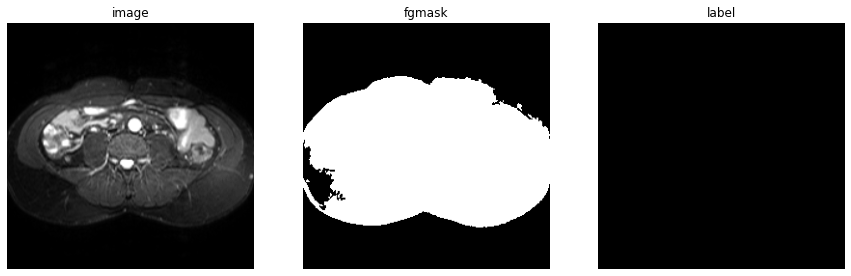

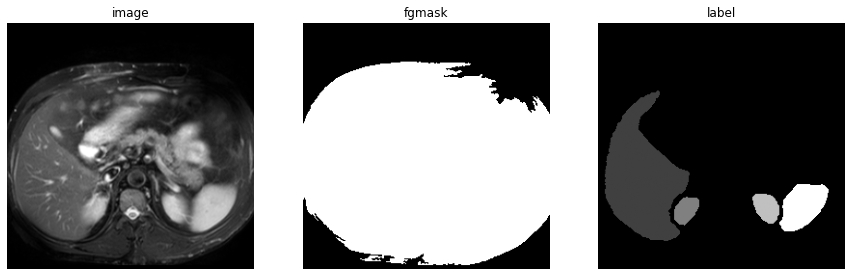

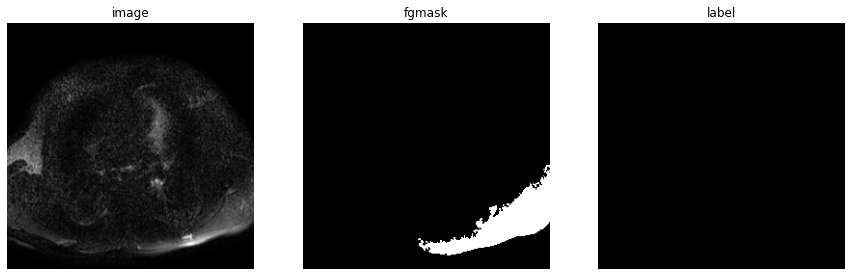

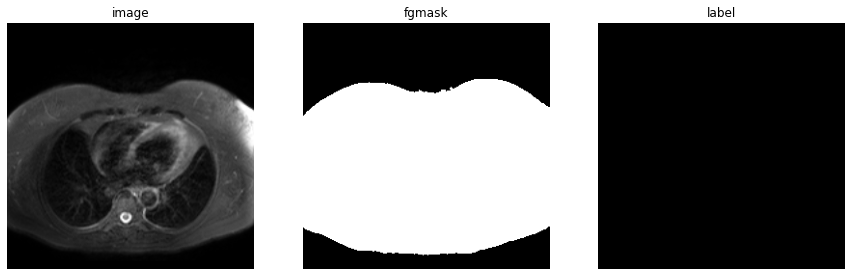

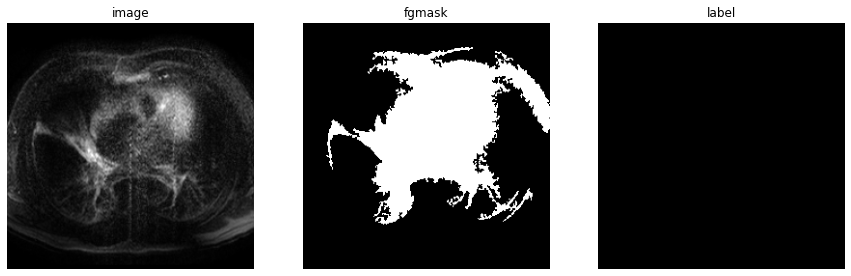

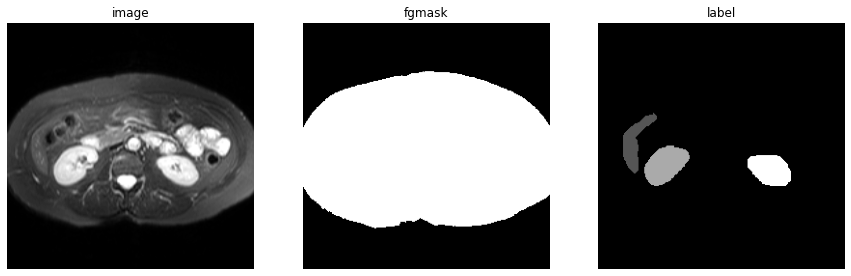

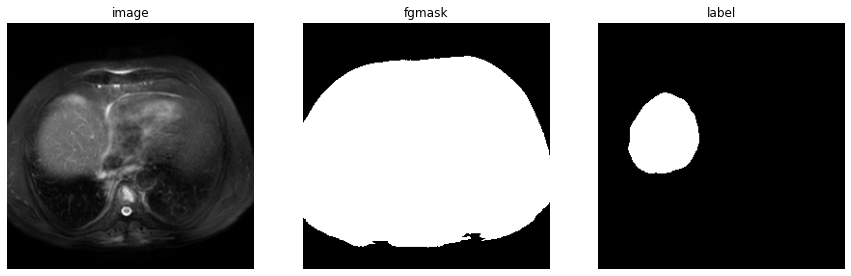

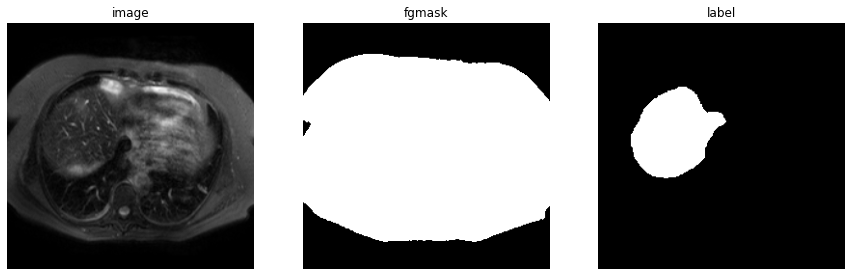

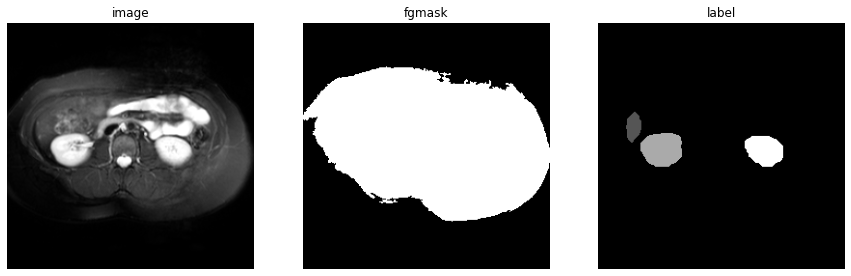

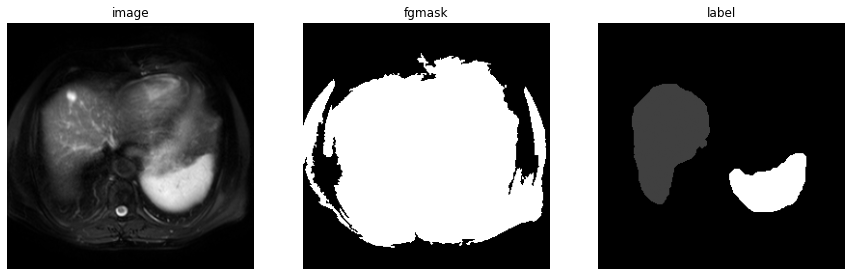

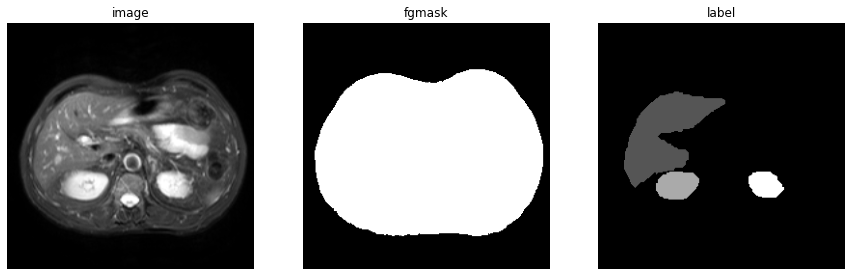

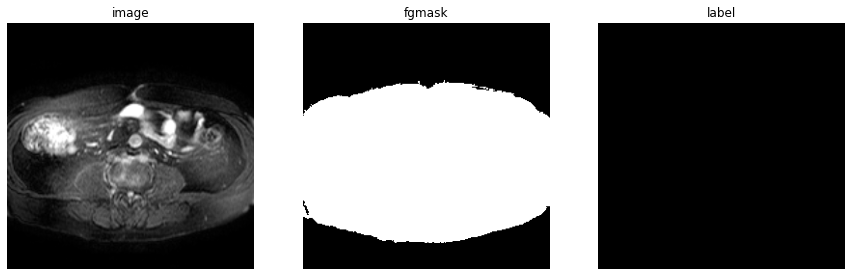

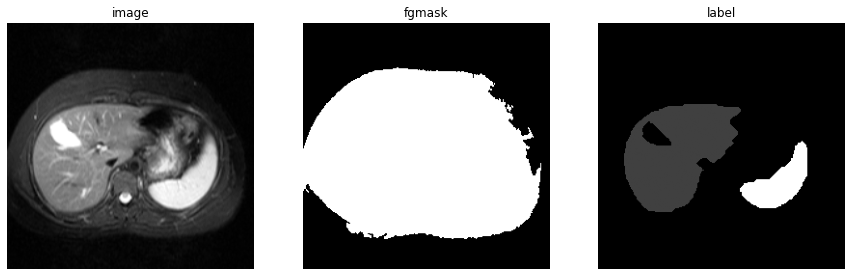

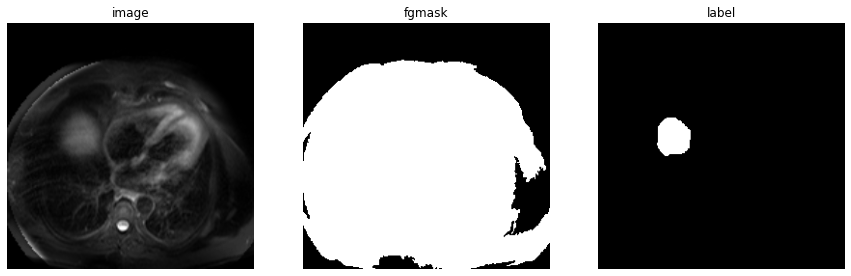

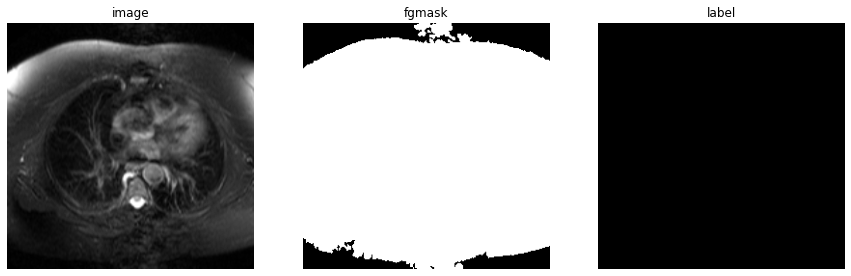

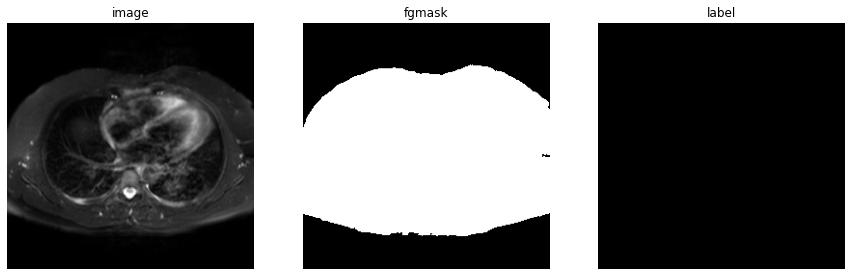

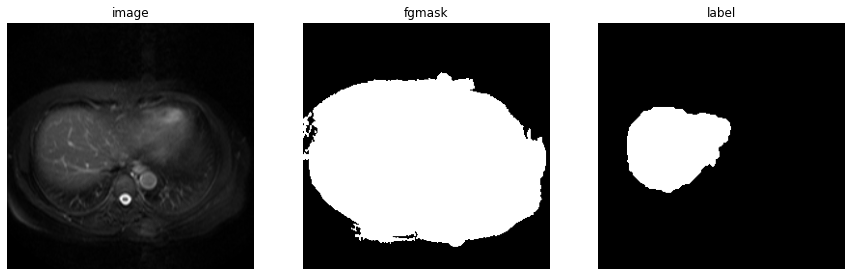

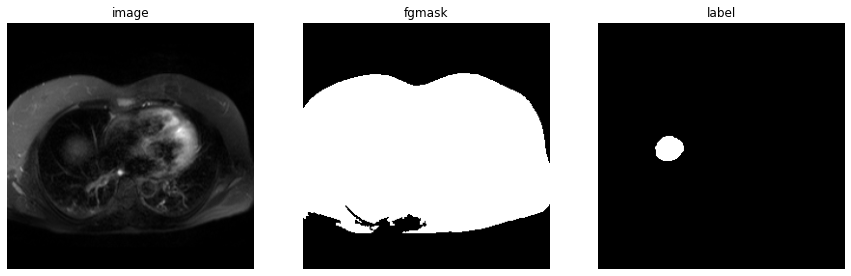

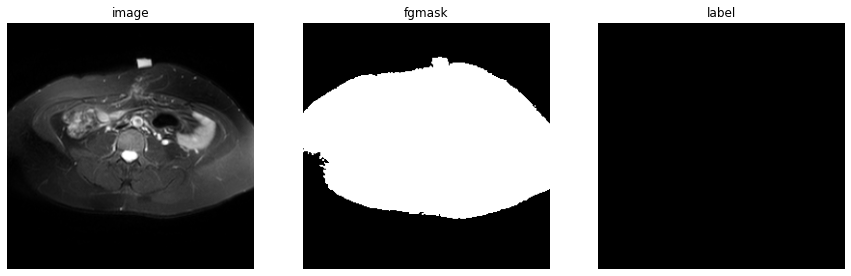

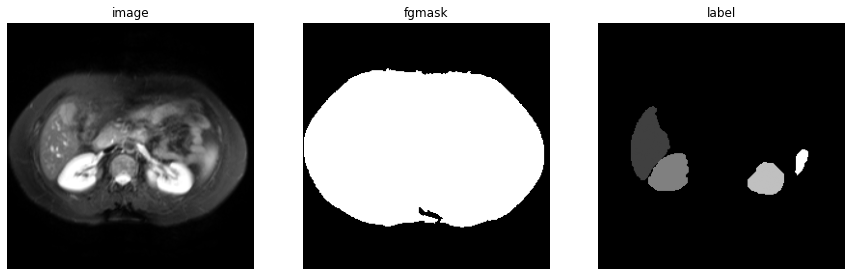

In [10]:
# Here I picked a random frame for each patient and plot corresponding image, fgmask and lable.
for id in patient_ids:
  num_frames = patients.get(id).frames_count
  picked_frame = randrange(num_frames)
  patients.get(id).plot(picked_frame)


# Split data to train and validation

In [11]:
X_train = []
x_val = []
x_labl = []

for id in patient_ids:
  for frame in range(patients.get(id).frames_count):
    img = patients.get(id).images[frame,:,:]
    labl = patients.get(id).labels[frame,:,:]
    if img.max() == 0: continue
    img = img / img.max()
    if id != 39:
      X_train.append(img)
    else:
      if labl.max() == 0: continue
      x_val.append(img)
      x_labl.append(labl)

X_train = np.array(X_train)
x_val = np.array(x_val)
x_labl = np.array(x_labl)

# Volxelmorph

In [12]:
nb_features = [
    [32, 32, 32, 32],         
    [32, 32, 32, 32, 32, 16]  
]
inshape = X_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 256, 256, 1), (None, 256, 256, 1)
output shape: (None, 256, 256, 1), (None, 256, 256, 2)


# Compile

In [13]:
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.01
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

# Fit

In [14]:
def vxm_data_generator(x_data, batch_size=32):

    vol_shape = x_data.shape[1:]
    ndims = len(vol_shape)
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)
train_generator = vxm_data_generator(X_train, batch_size = 32)

In [15]:
hist = vxm_model.fit(train_generator, epochs=100, steps_per_epoch=5, verbose=2);

Epoch 1/100


<ipython-input-15-8fca68976d4c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=100, steps_per_epoch=5, verbose=2);


5/5 - 16s - loss: 0.0442 - vxm_dense_transformer_loss: 0.0442 - vxm_dense_flow_loss: 6.0447e-08 - 16s/epoch - 3s/step
Epoch 2/100
5/5 - 1s - loss: 0.0431 - vxm_dense_transformer_loss: 0.0431 - vxm_dense_flow_loss: 6.5827e-07 - 1s/epoch - 296ms/step
Epoch 3/100
5/5 - 1s - loss: 0.0447 - vxm_dense_transformer_loss: 0.0447 - vxm_dense_flow_loss: 3.0718e-06 - 1s/epoch - 293ms/step
Epoch 4/100
5/5 - 1s - loss: 0.0448 - vxm_dense_transformer_loss: 0.0448 - vxm_dense_flow_loss: 1.0364e-05 - 1s/epoch - 295ms/step
Epoch 5/100
5/5 - 1s - loss: 0.0436 - vxm_dense_transformer_loss: 0.0436 - vxm_dense_flow_loss: 3.4573e-05 - 1s/epoch - 294ms/step
Epoch 6/100
5/5 - 1s - loss: 0.0443 - vxm_dense_transformer_loss: 0.0443 - vxm_dense_flow_loss: 8.1518e-05 - 1s/epoch - 294ms/step
Epoch 7/100
5/5 - 1s - loss: 0.0435 - vxm_dense_transformer_loss: 0.0435 - vxm_dense_flow_loss: 1.1679e-04 - 1s/epoch - 292ms/step
Epoch 8/100
5/5 - 1s - loss: 0.0429 - vxm_dense_transformer_loss: 0.0429 - vxm_dense_flow_loss: 

# Plot loss

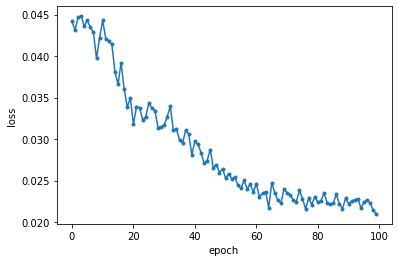

In [16]:
def plot_history(hist, loss_name='loss'):
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Visualize predictions

1/1 [==============================] - 0s 448ms/step


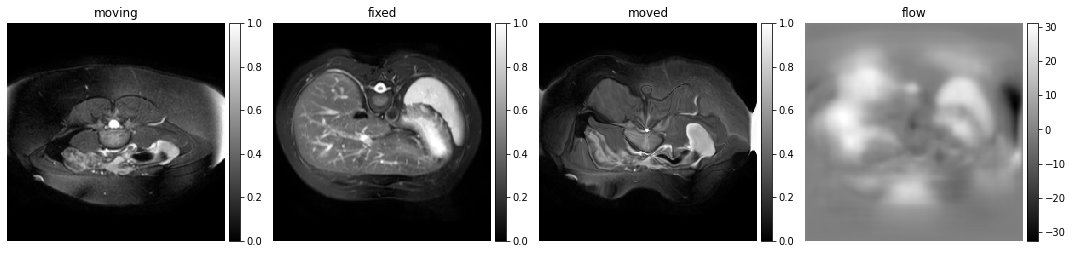

1/1 [==============================] - 0s 146ms/step


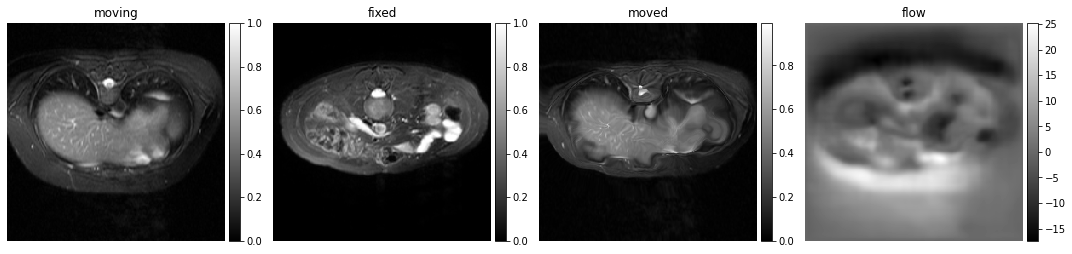

1/1 [==============================] - 0s 134ms/step


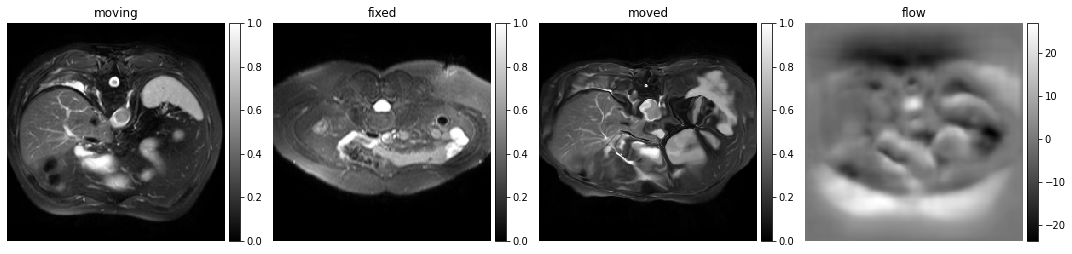

1/1 [==============================] - 0s 145ms/step


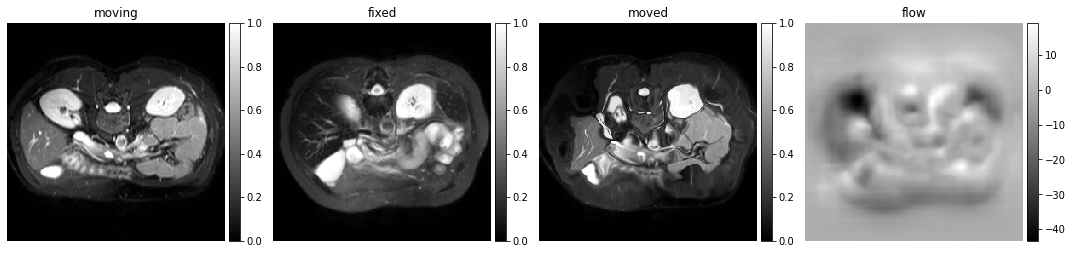

1/1 [==============================] - 0s 119ms/step


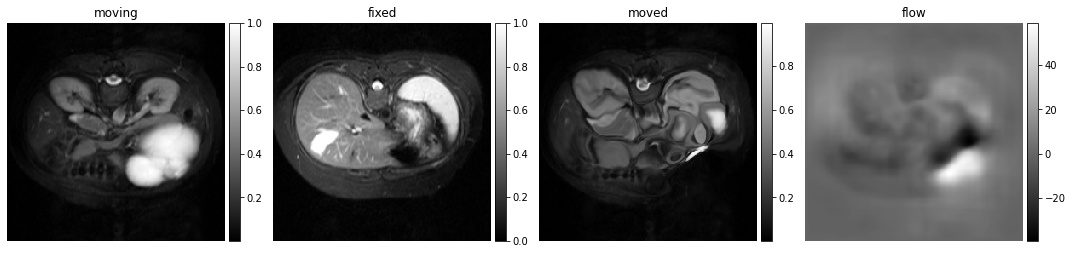

1/1 [==============================] - 0s 130ms/step


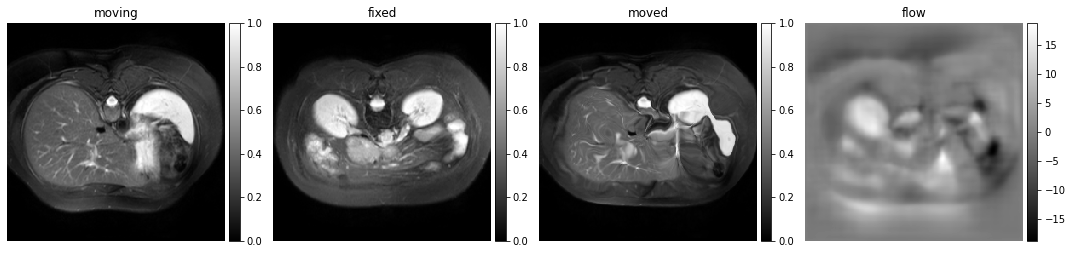

1/1 [==============================] - 0s 119ms/step


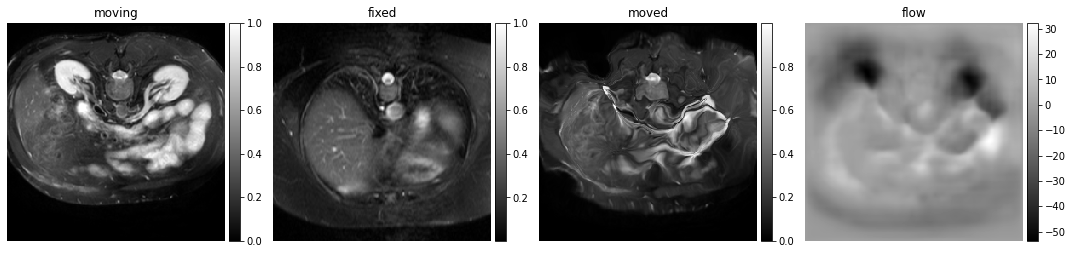

1/1 [==============================] - 0s 145ms/step


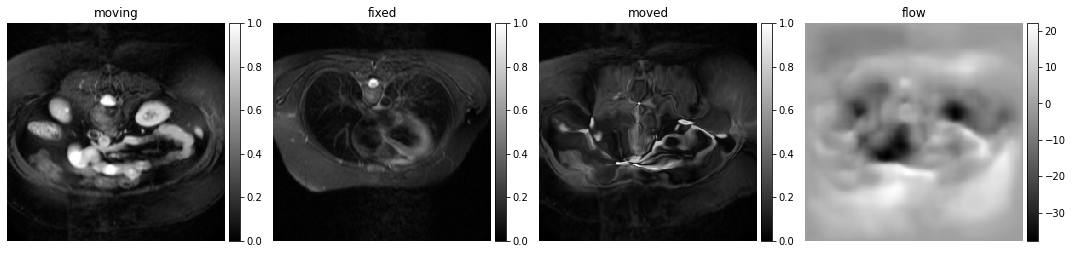

1/1 [==============================] - 0s 137ms/step


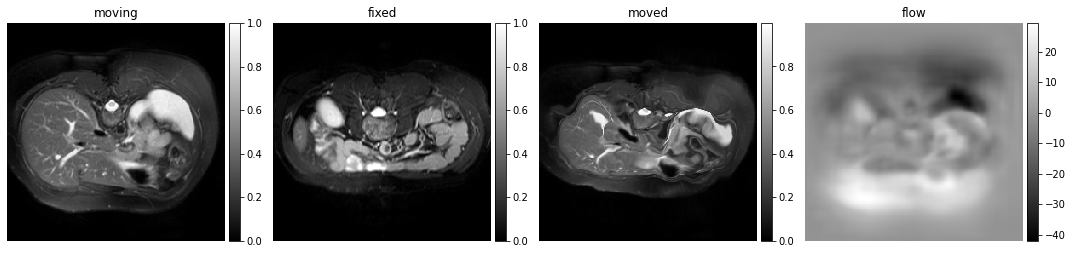

1/1 [==============================] - 0s 127ms/step


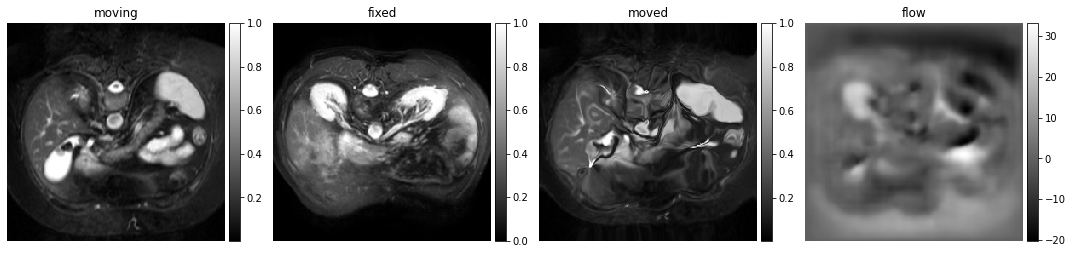

In [17]:
for i in range(10):
  val_input, _ = next(train_generator)
  val_pred = vxm_model.predict(val_input)
  images = [img[0, :, :, 0] for img in val_input + val_pred] 
  titles = ['moving', 'fixed', 'moved', 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# Testing

In [32]:
# Generator for last patient images and labels.
def vxm_val_generator(x_data, batch_size=1):    
    moving_images = x_data[[12], ..., np.newaxis]
    for count in range(len(x_data)):
        fixed_images = x_data[[count], ..., np.newaxis]
        yield [moving_images, fixed_images]

def vxm_labl_generator(x_data, batch_size=1):    
    middle_label = x_data[[12], ..., np.newaxis]
    for count in range(len(x_data)):
        labl = x_data[[count], ..., np.newaxis]
        yield middle_label, labl

val_generator = vxm_val_generator(x_val, batch_size = 1)
labl_generator = vxm_labl_generator(x_labl, batch_size = 1)

In [34]:
# Define Dice score for report.
def dice_score(x_true, x_pred):
  true = np.where(x_true > 0, 1, 0)
  pred = np.where(x_pred > 0, 1, 0)
  score = np.sum(pred[true==1]) / (np.sum(pred) + np.sum(true))
  return 2*score

Prediction for slice 1
1/1 [==============================] - 0s 20ms/step
0.026101141924959218
Prediction for slice 2
1/1 [==============================] - 0s 20ms/step
0.06405300938707896
Prediction for slice 3
1/1 [==============================] - 0s 20ms/step
0.29464285714285715
Prediction for slice 4
1/1 [==============================] - 0s 22ms/step
0.6194833153928956
Prediction for slice 5
1/1 [==============================] - 0s 21ms/step
0.721007016095749
Prediction for slice 6
1/1 [==============================] - 0s 21ms/step
0.794728839330968
Prediction for slice 7
1/1 [==============================] - 0s 25ms/step
0.8422509225092251
Prediction for slice 8
1/1 [==============================] - 0s 19ms/step
0.8565121412803532
Prediction for slice 9
1/1 [==============================] - 0s 23ms/step
0.8763386027536971
Prediction for slice 10
1/1 [==============================] - 0s 21ms/step
0.8657894736842106
Prediction for slice 11
1/1 [============================

<ipython-input-35-ae777ae761d0>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


0.6246230264324996
Prediction for slice 23
1/1 [==============================] - 0s 30ms/step
0.5459076861728641
Prediction for slice 24
1/1 [==============================] - 0s 31ms/step
0.6324228028503563
Prediction for slice 25
1/1 [==============================] - 0s 29ms/step
0.6359044995408631
Prediction for slice 26
1/1 [==============================] - 0s 32ms/step
0.5036780614452618


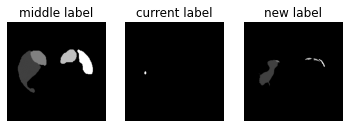

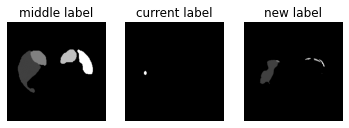

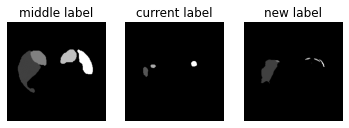

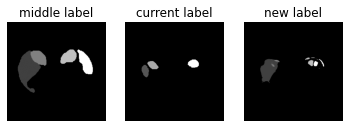

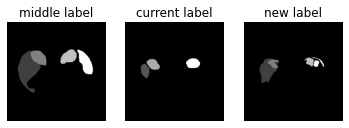

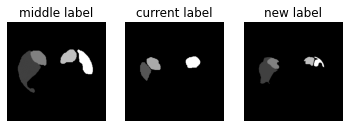

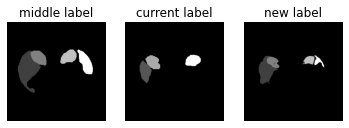

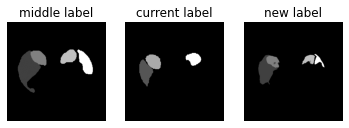

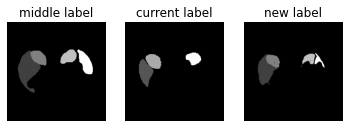

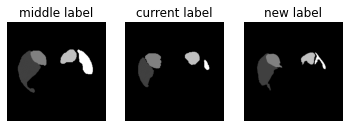

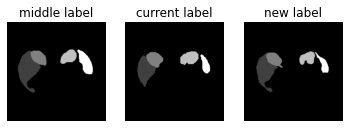

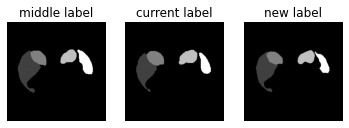

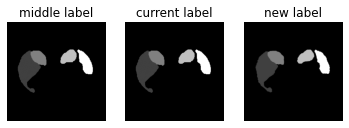

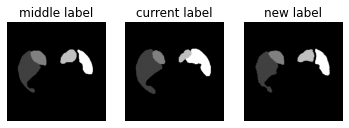

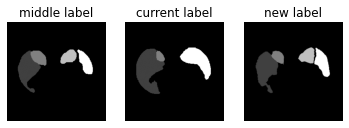

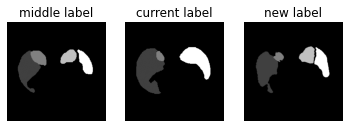

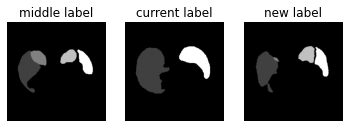

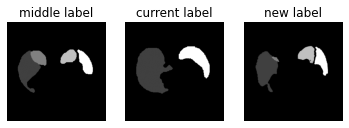

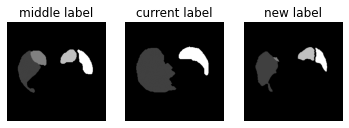

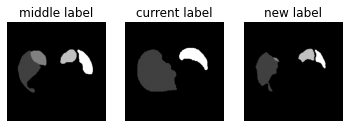

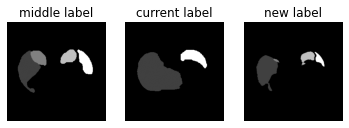

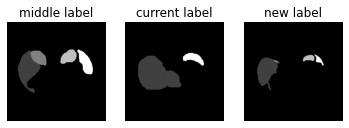

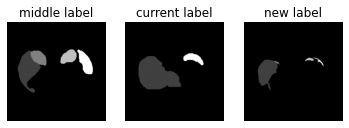

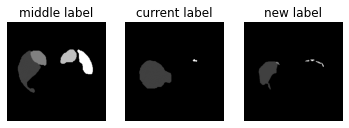

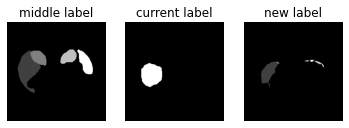

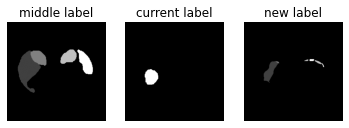

In [35]:
# Predict and visualize model ability to register whole slices of last patient based on the middle slice.
Result = 0
result = 0
for i in range(len(x_labl)):
  val_input = next(val_generator)
  print(f'Prediction for slice {i+1}')
  val_pred = vxm_model.predict(val_input)
  middle_label, current_label = next(labl_generator)
  new_label = vxm.layers.SpatialTransformer( interp_method='linear',indexing='ij')([middle_label,val_pred[1]])
  fig = plt.figure()
  ax1 = fig.add_subplot(1,3,1)
  ax1.imshow(middle_label[0,:,:,0], cmap='gray')
  plt.axis('off')
  plt.title('middle label')
  ax2 = fig.add_subplot(1,3,2)
  ax2.imshow(current_label[0,:,:,0], cmap ='gray')
  plt.axis('off')
  plt.title('current label')
  ax3 = fig.add_subplot(1,3,3)
  ax3.imshow(new_label[0,:,:,0], cmap='gray')
  plt.axis('off')
  plt.title('new label')
  result = dice_score(current_label[0,:,:,0], new_label[0,:,:,0])
  Result += result
  print(result)
plt.show()

In [36]:
print(f'Average Dice score: {Result/len(x_labl)}')

Average Dice score: 0.6879724192360215
